## Import Libraries

In [1]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import io
import pickle
import os
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.predictor import csv_serializer
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score 

## Get S3 Bucket and Prefix and the IAM Role 

In [2]:
role = get_execution_role()

s3_resource = boto3.resource('s3')
s3_client = boto3.client('s3')
income_bucket_name='hypatai-income-bucket'
income_bucket = s3_resource.Bucket(income_bucket_name)
prefix = 'sagemaker'

#Normally it is better to keep all generated data and model versions in S3 path 'hypatai-income-bucket/sagemaker', 
#below 2 lines are not comment out just for demonstration purposes
objects = income_bucket.objects.filter(Prefix=prefix)
objects.delete()

for obj in income_bucket.objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_model.pickle')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_train.csv')


## Function to read from S3

In [3]:
def read_from_s3(bucket_name,file_name,filetype):
    obj = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    if filetype=="csv":
        data=pd.read_csv(io.BytesIO(obj['Body'].read()))
        data=data[list(data.columns)[1:]]
    elif filetype=="pickle":
        with io.BytesIO() as data:
            s3_resource.Bucket(bucket_name).download_fileobj(file_name, data)
            data.seek(0)    
            data = pickle.load(data)

    return data

## Read Input Data for Training

In [4]:
trainXkey = 'XGBOOST_X_train.csv'
testXkey = 'XGBOOST_X_test.csv'
trainykey = 'XGBOOST_y_train.csv'
testykey = 'XGBOOST_y_test.csv'

#XGBOOST_X_train=read_from_s3(income_bucket_name,trainXkey,'csv')
#XGBOOST_X_test=read_from_s3(income_bucket_name,testXkey,'csv')
#XGBOOST_y_train=read_from_s3(income_bucket_name,trainykey,'csv')
#XGBOOST_y_test=read_from_s3(income_bucket_name,testykey,'csv')

XGBOOST_X_train=pd.read_csv('s3://'+income_bucket_name+'/'+trainXkey).iloc[:,1:]
XGBOOST_X_test=pd.read_csv('s3://'+income_bucket_name+'/'+testXkey).iloc[:,1:]
XGBOOST_y_train=pd.read_csv('s3://'+income_bucket_name+'/'+trainykey).iloc[:,1:]
XGBOOST_y_test=pd.read_csv('s3://'+income_bucket_name+'/'+testykey).iloc[:,1:]

## Read Existing model

In [5]:
#ex_model=read_from_s3(income_bucket_name,'XGBOOST_model.pickle','pickle')
ex_model=pd.read_pickle('s3://'+income_bucket_name+'/'+'XGBOOST_model.pickle')
ex_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=4241, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=4241, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Specify the Locations of the XGBoost Algorithm Containers

In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost','1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


## Convert Input Data into SageMaker Acceptable Format

In [7]:
XGBOOST_train_sage=pd.concat([XGBOOST_y_train,XGBOOST_X_train],axis=1)
n_first = int(XGBOOST_train_sage.shape[0]*0.8)
X_train_fit=XGBOOST_train_sage.iloc[:n_first]
X_train_valid=XGBOOST_train_sage.iloc[n_first:]

## Save Created Data on S3

In [8]:
out_sagemaker_fit_key="TrainDataFit-xgboost-sagemaker.csv"
out_sagemaker_valid_key="ValidData-xgboost-sagemaker.csv"

X_train_fit.to_csv(out_sagemaker_fit_key,header=False,index=False)
X_train_valid.to_csv(out_sagemaker_valid_key,header=False,index=False)

income_bucket.Object(os.path.join(prefix,out_sagemaker_fit_key)).upload_file(out_sagemaker_fit_key)
income_bucket.Object(os.path.join(prefix,out_sagemaker_valid_key)).upload_file(out_sagemaker_valid_key)

In [9]:
for obj in income_bucket.objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_model.pickle')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/TrainDataFit-xgboost-sagemaker.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/ValidData-xgboost-sagemaker.csv')


## Create s3_inputs where Training Function could Use as a Pointer to the Files in S3

In [10]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/sagemaker/{}'.format(income_bucket_name, out_sagemaker_fit_key), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/sagemaker/{}'.format(income_bucket_name, out_sagemaker_valid_key), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


## Start Training by Using SageMaker's  Built-in XGBoost Algorithm

In [11]:
sess = sagemaker.Session()
out_sagemaker_model_prefix="model-xgboost-sagemaker"

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/sagemaker/{}'.format(income_bucket_name, out_sagemaker_model_prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth= 6, 
                        eta = 0.3,
                        objective='binary:logistic',
                        seed= 4241,
                        min_child_weight = 5,
                        num_round = 250,
                        eval_metric='auc',
                        early_stopping_rounds=20)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-07 17:31:59 Starting - Starting the training job...
2020-11-07 17:32:01 Starting - Launching requested ML instances......
2020-11-07 17:33:07 Starting - Preparing the instances for training......
2020-11-07 17:34:23 Downloading - Downloading input data
2020-11-07 17:34:23 Training - Downloading the training image...
2020-11-07 17:35:00 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined deli

In [12]:
for obj in income_bucket.objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_model.pickle')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/TrainDataFit-xgboost-sagemaker.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/ValidData-xgboost-sagemaker.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/model-xgboost-sagemaker/sagemaker-xgboost-2020-11-07-17-31-59-274/output/model.tar.gz')


## Get the Prefix of the Model Version for Later Use

In [13]:
model_name=""
resp = s3_client.list_objects_v2(Bucket='hypatai-income-bucket')
for obj in resp['Contents']:
    if obj['Key'][:34]=='sagemaker/model-xgboost-sagemaker/':
        model_name=model_name.join(obj['Key'][34:75])
model_name

'sagemaker-xgboost-2020-11-07-17-31-59-274'

## Download SageMaker Model

In [14]:
!aws s3 cp s3://hypatai-income-bucket/sagemaker/model-xgboost-sagemaker/$model_name/output/model.tar.gz .

download: s3://hypatai-income-bucket/sagemaker/model-xgboost-sagemaker/sagemaker-xgboost-2020-11-07-17-31-59-274/output/model.tar.gz to ./model.tar.gz


In [15]:
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pickle.load(open('xgboost-model', 'rb'))

## Get Feature Names from Booster Object and Plot Top Features

In [16]:
list_keys=list(model.get_score().keys())
print(list_keys[:10])
new_keys=[]
for _key in list_keys:
    _key=int(_key.replace('f',''))
    new_keys.append(_key)
feature_list=list(XGBOOST_X_train.iloc[:,new_keys])

def plot_feature_importance(model,feature_names):

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': list(model.get_score(importance_type ='total_gain').values())})
    feature_importance.sort_values('importance', ascending = False, inplace = True)
    best_features = feature_importance.head(10)
    plt.figure(figsize = (8,6))
    sns.barplot(x = 'importance', y = 'feature', data = best_features)
    plt.show()
      

['f31', 'f2', 'f3', 'f4', 'f0', 'f22', 'f27', 'f45', 'f39', 'f55']


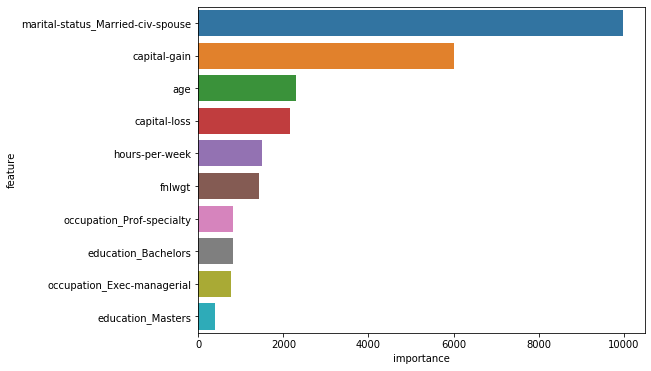

In [17]:
plot_feature_importance(model,feature_list)

## Deploy Model

In [18]:
serializer = csv_serializer
serializer.CONTENT_TYPE = "text/csv"

predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=serializer
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

## Get Predictions for the Validation Data

In [19]:
sagemaker_xgboost_preds_valid=predictor.predict(XGBOOST_X_train.iloc[n_first:].to_numpy()).decode('utf-8').split(",")
sagemaker_xgboost_preds_valid=[float(pred.replace("'","")) for pred in sagemaker_xgboost_preds_valid ]

In [20]:
sagemaker_xgboost_preds_valid[:10]

[0.06363335996866226,
 0.2846936583518982,
 0.5771022439002991,
 0.015583465807139874,
 0.04267227277159691,
 0.9511284828186035,
 0.7952181100845337,
 0.05299854651093483,
 0.01479530893266201,
 0.14712756872177124]

## Plot Roc Curve

In [21]:
def plot_roc_curve (y, y_pred,which_set):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.3f)' % (roc_auc))
    plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for '+ which_set+ ' Set')
    plt.legend()
    plt.show()
    
    return y_pred, fpr, tpr, threshold

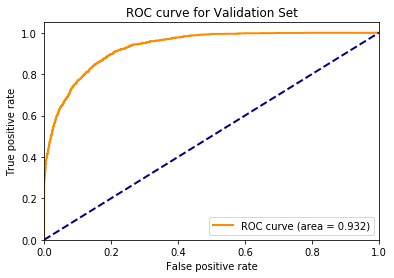

In [22]:
y_pred_valid, fpr_valid, tpr_valid, threshold_valid =plot_roc_curve(XGBOOST_y_train.iloc[n_first:],sagemaker_xgboost_preds_valid,which_set="Validation")

## Save Predictions on S3

In [23]:
out_sagemaker_pred_key="ValidDataPred-xgboost-sagemaker.csv"
sagemaker_xgboost_preds_valid=pd.DataFrame({"y_pred":sagemaker_xgboost_preds_valid })
sagemaker_xgboost_preds_valid.to_csv(out_sagemaker_pred_key,header=False,index=False)
prefix_pred="sagemaker/preds-xgboost-sagemaker/"+model_name+"/output"

income_bucket.Object(os.path.join(prefix_pred,out_sagemaker_pred_key)).upload_file(out_sagemaker_pred_key)

In [24]:
for obj in income_bucket.objects.all():
    print(obj)

s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_X_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_model.pickle')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_test.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='XGBOOST_y_train.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/TrainDataFit-xgboost-sagemaker.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/ValidData-xgboost-sagemaker.csv')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/model-xgboost-sagemaker/sagemaker-xgboost-2020-11-07-17-31-59-274/output/model.tar.gz')
s3.ObjectSummary(bucket_name='hypatai-income-bucket', key='sagemaker/preds-xgboost-sagemaker/sagemaker-xgboost-2020-11-07-17-31-59-274/output/ValidDataPred-xgboost-sagemaker.csv')


In [25]:
sagemaker.Session().delete_endpoint(predictor.endpoint)